In [1]:
import pickle, copy, json, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.stats as sps
from random import shuffle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import la_forge.utils as lf_utils
lf_utils.set_publication_params({'text.usetex':False})
fig_dir = '/home/baierj/projects/hasasia2/hasasia2_paper/figures/'
os.chdir('/home/baierj/projects/hasasia2/pta_sensitivity_tuning/')

In [2]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.utils as utils
import hasasia.skymap as hsky

In [3]:
import jax
jax.config.update("jax_enable_x64", True)

In [4]:
import healpy as hp
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord
#import plot #Script originally written by Leo Stein for making pretty sky maps. 

# Setting various healpy quantities and GW source sky positions.
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [45]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]
def sky_ave_detect(sm,snr=3):
    #snr /= 2
    return snr*np.sqrt(np.mean(sm.S_eff,axis=1)/sm.Tspan)
def sky_detect(sm,snr=3):
    # snr /= 2 -- cnhanged hasasia source code. don't need to worry about factor of 2 any more
    return snr*np.sqrt(sm.S_eff/sm.tspan)
#Note the factor of 2 here is due to a difference in the definition of h0 between hasasia and this work
fyr = 1/(365.25*24*3600)
days = 24*3600
yr_sec = 365.25*24*3600
freqs = np.logspace(np.log10(3e-10),np.log10(2e-7),300)
## injecting GWB from 3P+ https://arxiv.org/pdf/2309.00693.pdf
# not included in paper, but these values are from Paul Baker 
# they are the 2D joint emperical distr. ---> gamma = 3.44; log10A = -14.29
A_gwb = -14.29
gamma_gwb = 3.44
alpha_gwb = (3. - gamma_gwb) / 2.
S_h = hsen.S_h(A=10**A_gwb, alpha=alpha_gwb, freqs=freqs)

In [24]:
def get_sliced_spectra(psrs, 
                       start_mjd=1,
                       end_mjd = None,
                       ):
    """
    Parameters 
    ----------
    
    psrs : list of enterprise.Pulsar or list of hasasia.Pulsar objects
        List of enterprise/hasasia Pulsar objects
        
    cutoff : float
        MJD cutoff for the calculation
    
    sigma_correction : ?
        ???
    """
    psrs_cut = []
    psrs_copy = copy.deepcopy(psrs)
    for idx, psr in enumerate(psrs_copy):
        # filter the data around to the appropriate slice
        #print("N_toa = ", len(psr.toas))
        psr.filter_data(start_time=start_mjd, end_time=end_mjd)
        #print("after filter = ", len(psr.toas)) 
        # If there are no TOAs remaining, or the time span of the pulsar is <3 cut.
        if (psr.toas.size == 0) or (hsen.get_Tspan([psr]) < 3*365.25*24*3600):
    #         idxs.append(idx)
            pass
        else:
            psrs_cut.append(psr)
    timespan = hsen.get_Tspan(psrs_cut)
    spectra = []
    for idx, p in enumerate(psrs_cut):
        sp = hsen.Spectrum(p,freqs=freqs)
        sp.name = p.name
        _ = sp.NcalInv
        #print(f"psr spectra {idx} is done")
        spectra.append(sp)
    print(f"PTA spectrum with {len(spectra)} psrs created.")
    return spectra

In [25]:
def distance_on_sphere(lat1, lon1, lat2, lon2):
    ''''
    Returns the distance between two points on the surface of the unit sphere.
    
    Parameters
    ==========
    lat1, lat2 - float
        lattitude of first and second point respectively
    lon1, lon2 - float
        longitude of first and second point respectively
    Returns
    =======
    distance - float
        distance between two points
    '''
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula for distance
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = c
    
    return distance

In [26]:
distance_on_sphere?

Signature: distance_on_sphere(lat1, lon1, lat2, lon2)
Docstring:
'
Returns the distance between two points on the surface of the unit sphere.

Parameters
lat1, lat2 - float
    lattitude of first and second point respectively
lon1, lon2 - float
    longitude of first and second point respectively
Returns
distance - float
    distance between two points
File:      /tmp/ipykernel_1891084/1556492675.py
Type:      function

In [27]:
distance_on_sphere(0,0,np.pi/2,np.pi/2)

1.5707963267948966

# 1) Load `hsen.Pulsars` created in `creating_pta.ipynb` and create sources

In [28]:
proj_dir = '/home/baierj/projects/hasasia2/pta_sensitivity_tuning'
#proj_dir = '.'
def reset_psrs():
    gpta_psrs_40yrs = []
    for i in range(157):   
        with open(f'{proj_dir}/data/gpta_psrs_40yrs_v2/gpta_psr_{i}_v2.pkl', 'rb') as fp:
            gpta_psrs_40yrs.append(pickle.load(fp))
    print("Loaded ", len(gpta_psrs_40yrs), " `hsen.Pulsars` in from `creating_pta.ipynb`.")
    return gpta_psrs_40yrs
gpta_psrs_40yrs = reset_psrs()

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [29]:
# sources
#mass in Msun, D_L in Mpc, f(_GW?) in Hz
h0_freqs = [8e-9] #[1e-9, 8e-9, 2.15e-8, 4.8e-8]
s1 = hsky.h0_circ(M_c=10e9,D_L=10**3.9, f0=h0_freqs[0]).to('')
s2 = hsky.h0_circ(M_c=10e9,D_L=10**3.9, f0=h0_freqs[0]).to('')
s3 = hsky.h0_circ(M_c=10e9,D_L=10**3.9, f0=h0_freqs[0]).to('')
s4 = hsky.h0_circ(M_c=10e9,D_L=10**3.9, f0=h0_freqs[0]).to('')
source_h0s = [s1.value, s2.value, s3.value, s4.value]
source_freq = [np.argmin(abs(freqs-h0_freqs[i])) for i in range(len(h0_freqs))][0]
source_h0s

[2.7782581533747338e-15,
 2.7782581533747338e-15,
 2.7782581533747338e-15,
 2.7782581533747338e-15]

In [30]:
skyloc5 = [np.deg2rad(133.7036*u.deg), np.pi/2*u.rad - np.deg2rad(20.1085*u.deg)]
skyloc6 = [np.deg2rad(300.*u.deg), np.pi/2*u.rad - np.deg2rad(30.*u.deg)]
skyloc7 = [np.deg2rad(60.*u.deg), np.pi/2*u.rad - np.deg2rad(30.*u.deg)]
skyloc8 = [np.deg2rad(280.*u.deg), np.pi/2*u.rad - np.deg2rad(-20.*u.deg)]
source_thetas = [skyloc5[1].value, skyloc6[1].value, skyloc7[1].value, skyloc8[1].value]
source_phis = [skyloc5[0].value, skyloc6[0].value, skyloc7[0].value, skyloc8[0].value]
source_pixels = [hp.ang2pix(NSIDE, source_thetas[i], source_phis[i]) for i in range(len(source_phis))]
# theta_ipta =  [np.pi/2- np.deg2rad(dr3_dec[i]) for i in range(len(dr3_dec))]
# phi_ipta = [np.deg2rad(dr3_ra[i]) for i in range(len(dr3_ra))]

# Source Properties
|Source Name| Mass [ Msun ] | $L_\text{D}$ [Log10 Mpc] | $f_{\text{GW}}$ [Log10 Hz] | $h_0$ [ ] | ra [ deg ] | dec [ deg ] |
|:---:|:---:|:---:|:-------:|:----:| :----:| :----:|  
|S5 | $10^9$ | $3.2$ | -8.15 | 1.77e-15 |  133.7036 | 20.1085 |
|S6 | $10^9$ | $3.2$  | -8.15 | 1.77e-15 |  300 | 30 |
|S7 | $10^9$ | $3.2$ | -8.15 | 1.77e-15 |  300 | 30 |
|S8 | $10^9$ | $3.2$ | -8.15 | 1.77e-15 |  250 | −10 |

referencing [Liu et al.](https://iopscience-iop-org.oregonstate.idm.oclc.org/article/10.3847/1538-4357/acb492/pdf)

In [31]:
theta_gpta = [psr.theta for psr in gpta_psrs_40yrs]
phi_gpta = [psr.phi for psr in gpta_psrs_40yrs]

In [32]:
start_year = 20.
gpta_psrs_20yrs = [gpta_psrs_40yrs[idx] for idx in range(len(gpta_psrs_40yrs)) if min(gpta_psrs_40yrs[idx].toas)<=start_year*yr_sec ]
theta_gpta_20yrs = [psr.theta for psr in gpta_psrs_20yrs]
phi_gpta_20yrs = [psr.phi for psr in gpta_psrs_20yrs]
test_distances = [distance_on_sphere(source_thetas[1], source_phis[1], theta_gpta[i], phi_gpta[i]) for i in range(len(gpta_psrs_20yrs))]

In [33]:
test_distances

[0.6428436282606008,
 1.0900579791152551,
 0.847186561389529,
 0.7781656305980198,
 0.5424747188122536,
 0.9625143944705244,
 0.5542107679363252,
 1.4783196573277377,
 1.6912581467752958,
 0.5055012754127743,
 1.2556597559884648,
 0.5999103206462115,
 0.42196701818707255,
 1.5876733878792109,
 1.1447677484999192,
 0.35528312750738694,
 0.907119740300743,
 0.45502387163632574,
 0.5830452831493951,
 1.423410573240843,
 1.7496035854090461,
 1.2607795901110679,
 0.6074159760512078,
 1.2421325228168187,
 0.5629859515406007,
 0.9514718476516868,
 0.6662039556262066,
 1.4260596505451852,
 0.7313684171366842,
 0.528215432020123,
 0.29228076696117966,
 0.4129077290193188,
 0.5991564037597163,
 0.8203533921259061,
 0.79077341718765,
 0.1762015750859788,
 0.9069819386646253,
 0.15267610456269107,
 1.6010573254174068,
 0.22379976124248774,
 0.43357259111073554,
 0.5669305332598635,
 1.0010206475197654,
 0.769394028822586,
 0.4212006768739369,
 0.9998238525817277,
 0.4367937343428335,
 0.1452395194

In [34]:
N = 10
nearest_idxs = []
for s_idx in range(len(source_h0s)):
    test_distances = [distance_on_sphere(np.pi/2 - source_thetas[s_idx], source_phis[s_idx], np.pi/2 - theta_gpta_20yrs[psr_idx], phi_gpta_20yrs[psr_idx]) for psr_idx in range(len(gpta_psrs_20yrs))]
    std = sorted(test_distances)
    #idxes = [test_distances.index(std[i]) for i in range(5)]
    idxes = np.argpartition(test_distances, N)[:N]
    nearest_idxs.append(idxes)

In [35]:
nearest_idxs

[array([77, 81, 60, 57, 54, 76, 65, 14, 82, 88]),
 array([ 79,  53,  59, 108,  47, 104,  63,  48,  94,  30]),
 array([ 54,  90, 117,  99,  64,  65,  51,  58,  34,  77]),
 array([ 33,  73,   5,  86,  45, 105,  22,  91,   2, 100])]

In [36]:
test_sky=np.zeros(NPIX)
for i in range(len(source_phis)): 
    test_sky[source_pixels[i]]+=100

In [37]:
color1= '#805D93'
color2 = '#F96E46'
color3 = '#A2AD59'
color3= '#FFD400'
teal= '#5D9DAD'

In [38]:
nearest_idxs, theta_gpta_20yrs

([array([77, 81, 60, 57, 54, 76, 65, 14, 82, 88]),
  array([ 79,  53,  59, 108,  47, 104,  63,  48,  94,  30]),
  array([ 54,  90, 117,  99,  64,  65,  51,  58,  34,  77]),
  array([ 33,  73,   5,  86,  45, 105,  22,  91,   2, 100])],
 [1.83813931525389,
  2.145331391076658,
  1.9414864585889502,
  1.8302629308107983,
  1.5909776035020227,
  2.0196888577617034,
  1.6152412220157115,
  2.6073977693361736,
  2.793767960080875,
  1.5213791939912116,
  2.36350646430845,
  1.7982223646290112,
  1.8766784580293847,
  2.6789462306909306,
  0.812844509413655,
  0.874121301461409,
  0.5202490694652829,
  2.482268789936547,
  2.320454172818422,
  2.5613661881326855,
  2.8886763383920058,
  2.387093106512408,
  1.6631212220723566,
  2.327981898767177,
  0.9927098045312894,
  2.0088587598541925,
  1.07012829790765,
  2.7192905667831075,
  1.7841009440456312,
  1.5754133744807806,
  1.3130184133962335,
  2.308006264968955,
  1.652441817001288,
  1.8774587932400189,
  0.5111831683630019,
  1.9684518

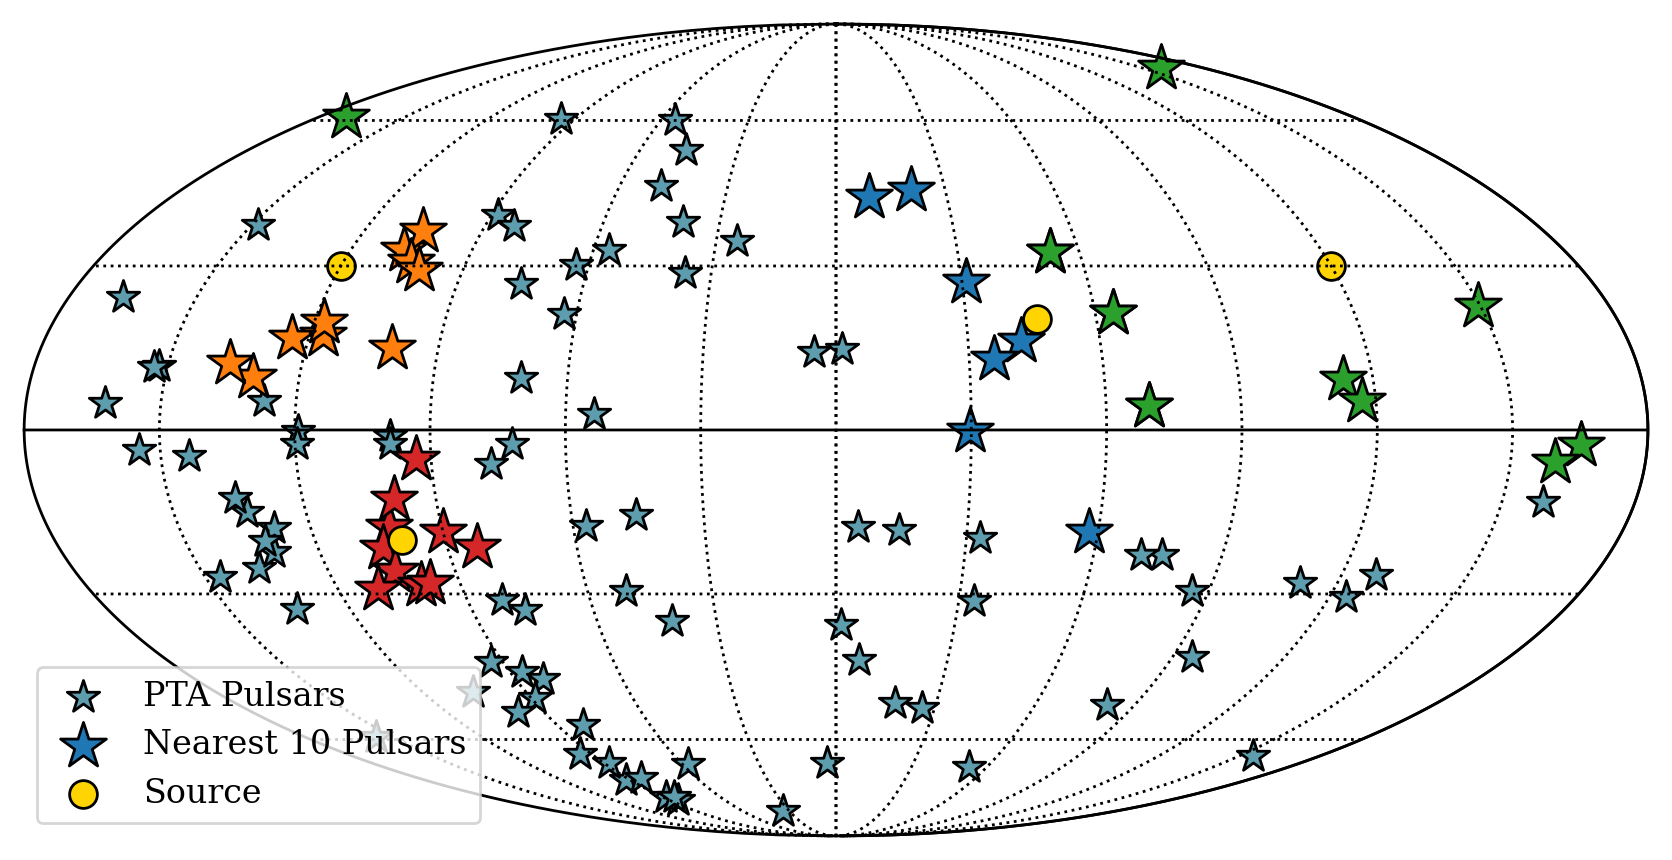

In [39]:
# visualize sources and pulsars
N = 10
hp.mollview(rot = (180,0,0),
            cmap='jet_r',cbar=None,title='')
hp.visufunc.projscatter(theta_gpta_20yrs, phi_gpta_20yrs,marker='*',
                        color=teal,edgecolors='k',s=150, label="PTA Pulsars")
for src_idx in range(len(source_h0s)):
    if src_idx == 0:
        hp.visufunc.projscatter([theta_gpta_20yrs[i] for i in nearest_idxs[src_idx][:N]], 
                                [phi_gpta_20yrs[i] for i in nearest_idxs[src_idx][:N]], marker='*',
                                color=f"C{src_idx}" ,edgecolors='k',s=300, label = f"Nearest {N} Pulsars")
    else:
       hp.visufunc.projscatter([theta_gpta_20yrs[i] for i in nearest_idxs[src_idx][:N]], 
                                [phi_gpta_20yrs[i] for i in nearest_idxs[src_idx][:N]], marker='*',
                                color=f"C{src_idx}" ,edgecolors='k',s=300) 
hp.visufunc.projscatter(source_thetas, source_phis, marker='.',
                        color=color3,edgecolors='k',s=400, label = "Source")
hp.graticule()
plt.legend(loc='lower left', fontsize=12)
fig = plt.gcf()
ax = plt.gca()
#plt.title('GPTA Pulsars and Test Sources')
#plt.savefig(f'{fig_dir}/psrs_test_srcs.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### pick out 5 pulsars closest to sources in order

# 3) Visualize how sensitivity to each source changes under std. campaign

In [40]:
# take one slice every year from NG15 to the end of the data set (40yrs)
start = 16
end = 40
slice_cad = 1
yearly_years = np.linspace(start, end, (end-start)*slice_cad+1)

In [42]:
yearly_SM = []
yearly_SNR = []
yearly_GWBSNR = []
for year in yearly_years:
    yearly_spectra = get_sliced_spectra(
            psrs=gpta_psrs_40yrs,
            start_mjd=-1000,
            end_mjd=365.25*year
        )
    yearly_GWBSNR.append(hsen.GWBSensitivityCurve(spectra=yearly_spectra, orf='hd', autocorr=False).SNR(S_h))
    yearly_SM.append(hsky.SkySensitivity(spectra=yearly_spectra, theta_gw=theta_gw, phi_gw=phi_gw))
    yearly_SNR.append([yearly_SM[-1].SNR(h_0) for h_0 in source_h0s])

PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 115 psrs created.
PTA spectrum with 117 psrs created.
PTA spectrum with 119 psrs created.
PTA spectrum with 121 psrs created.
PTA spectrum with 123 psrs created.
PTA spectrum with 125 psrs created.
PTA spectrum with 127 psrs created.
PTA spectrum with 129 psrs created.
PTA spectrum with 131 psrs created.
PTA spectrum with 133 psrs created.
PTA spectrum with 135 psrs created.
PTA spectrum with 137 psrs created.
PTA spectrum with 139 psrs created.
PTA spectrum with 141 psrs created.
PTA spectrum with 143 psrs created.
PTA spectrum with 144 psrs created.
PTA spectrum with 145 psrs created.
PTA spectrum with 148 psrs created.
PTA spectrum with 149 psrs created.
PTA spectrum with 152 psrs created.


In [43]:
color_map = plt.cm.jet_r(np.linspace(0,1,len(yearly_years)))

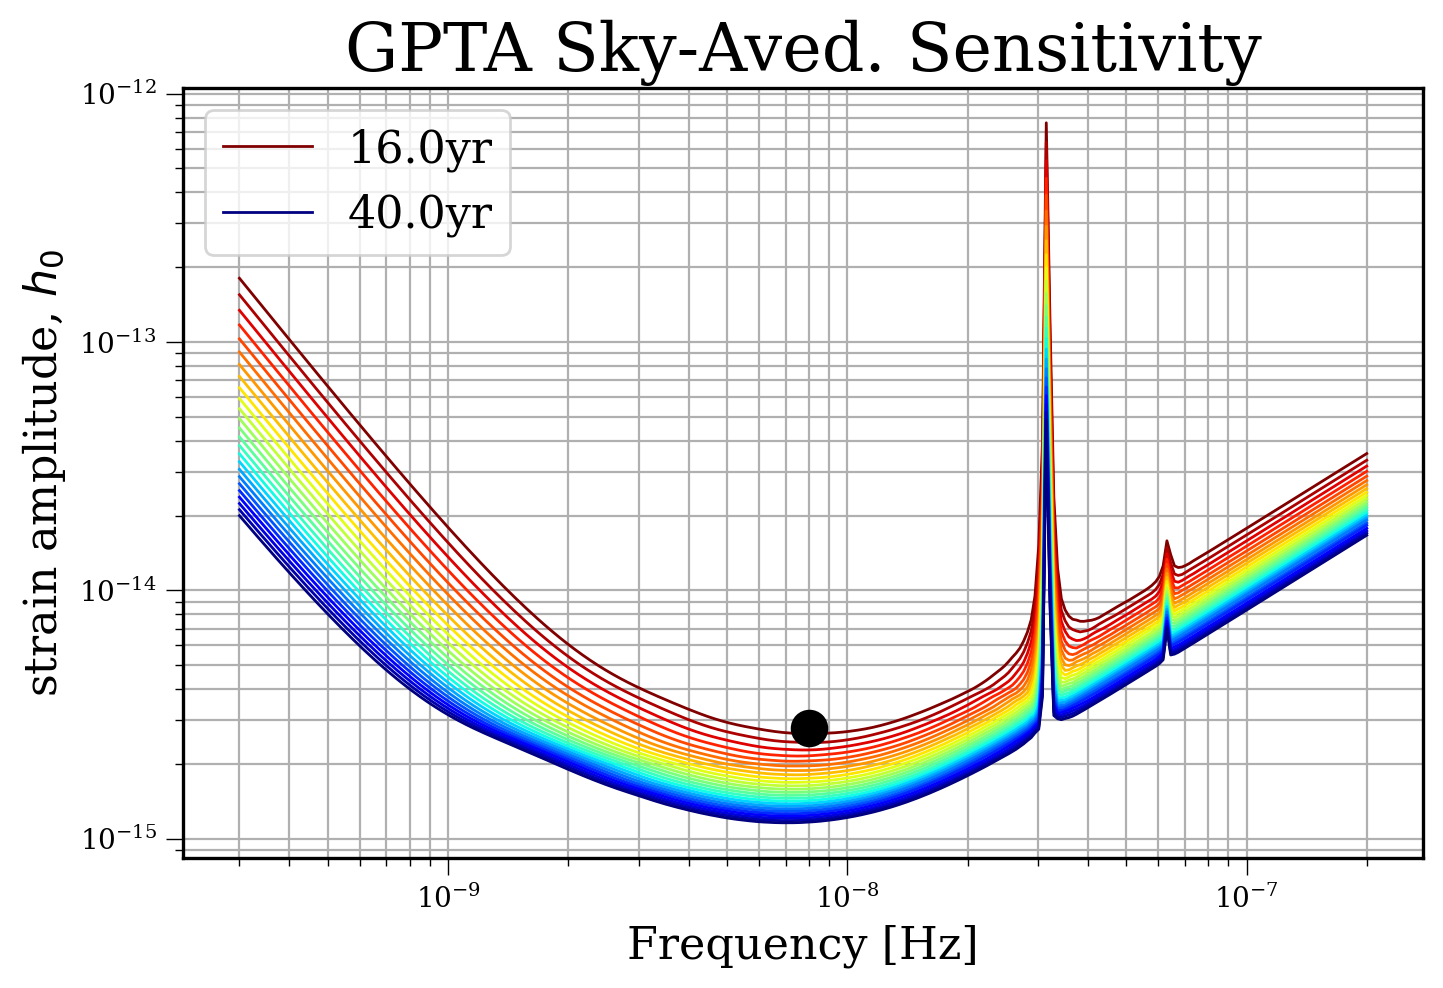

In [46]:
# Plot GWB SC
plt.figure(figsize=[8,5])
for i, sc in enumerate(yearly_SM):
    linewidth=1
    if yearly_years[i] == yearly_years[-1] or yearly_years[i]==yearly_years[0]:
        plt.loglog(sc.freqs, sky_ave_detect(sc, 3.52),label=f"{yearly_years[i]:.1f}yr", color = color_map[i], linewidth=linewidth, alpha=1)
    else:
        plt.loglog(sc.freqs, sky_ave_detect(sc, 3.52), color = color_map[i], linewidth=linewidth, alpha=1)
[plt.plot(h0_freqs[0], source_h0s[0], marker='.', markersize=25, color='black') ]#for src in range(len(source_h0s))]
plt.legend(loc='upper left', fontsize=16,)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('strain amplitude, $h_0$', fontsize=16)
plt.title('GPTA Sky-Aved. Sensitivity', fontsize = 24)
plt.grid(which='both')
plt.show()

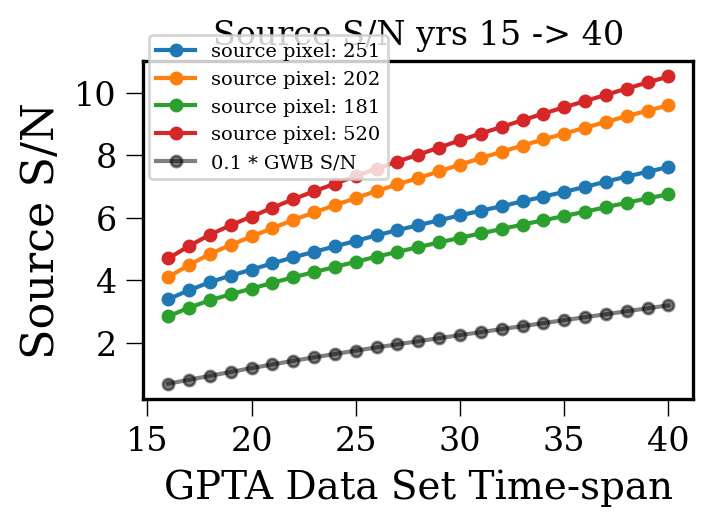

In [48]:
src_snr = np.array(yearly_SNR).T
for i in range(len(source_pixels)):
    plt.plot(yearly_years, src_snr[source_pixels[i]][source_freq][i], marker='o', color=f"C{i}", label=f"source pixel: {source_pixels[i]:.0f}")
plt.plot(yearly_years, 0.1*np.array(yearly_GWBSNR), marker='o', color='k', label="0.1 * GWB S/N", alpha=0.5)
plt.title("Source S/N yrs 15 -> 40")
plt.xlabel("GPTA Data Set Time-span", fontsize=14)
plt.ylabel("Source S/N", fontsize=16)
plt.legend(loc=(0.01,0.65))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [49]:
src_snr.shape, src_snr.T[-1][0][source_freq]#[:][source_freq][0][-1]

((768, 300, 4, 25),
 array([ 7.57304228,  7.6195066 ,  7.84794613,  7.81618337,  7.53766371,
         7.39880304,  7.46173958,  7.65903597,  7.8927743 ,  8.05399537,
         8.03220572,  7.81256595,  7.52247829,  7.31977175,  7.2605257 ,
         7.33569058,  7.49936027,  7.70895874,  7.93325037,  8.1339797 ,
         8.25591289,  8.24506387,  8.08309883,  7.81115866,  7.51976368,
         7.28409756,  7.15653761,  7.14670138,  7.23255511,  7.38010052,
         7.56220551,  7.76431589,  7.97714325,  8.18494313,  8.35924549,
         8.46292336,  8.46241454,  8.3418654 ,  8.11319945,  7.8181174 ,
         7.52911847,  7.27265168,  7.10153133,  7.03152082,  7.05552992,
         7.15072421,  7.29058603,  7.45491816,  7.63361708,  7.82413288,
         8.02513585,  8.22993571,  8.42286447,  8.58019566,  8.67501524,
         8.68403419,  8.59417174,  8.40735029,  8.14257849,  7.83468504,
         7.55104252,  7.28044271,  7.07924919,  6.96464868,  6.93804486,
         6.98667147,  7.0897125

In [50]:
source_freq
yr30_idx = list(yearly_years).index(30.0)

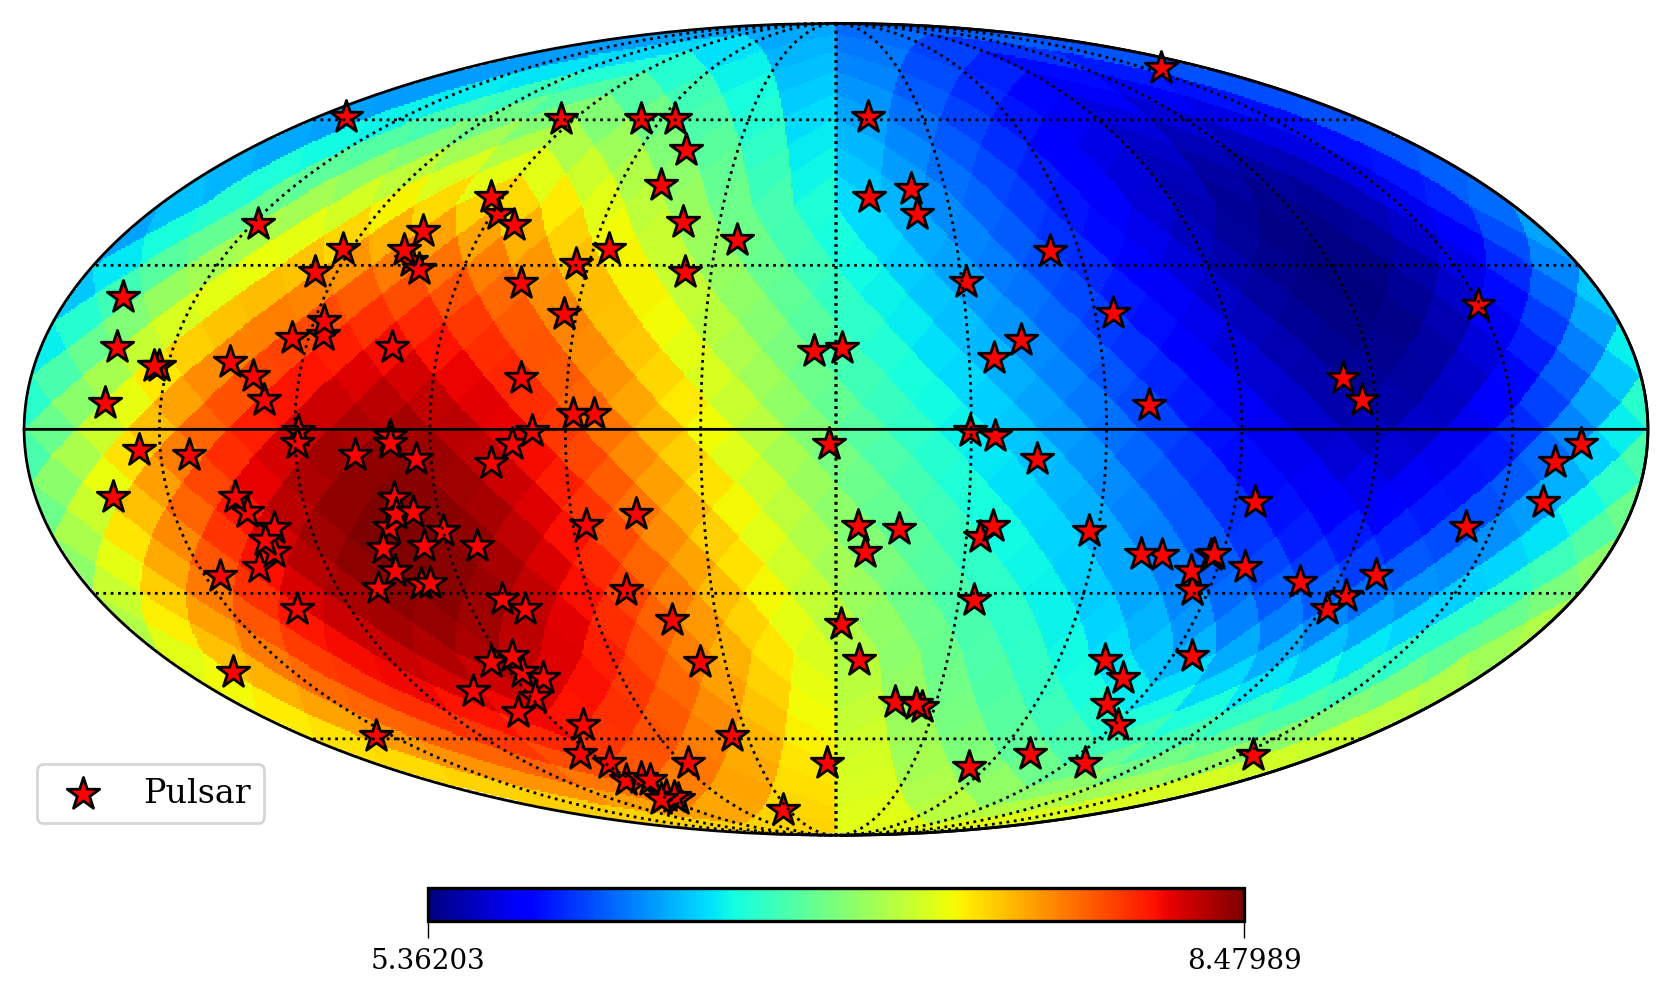

In [51]:
# visualize sources and pulsars
hp.mollview(src_snr.T[yr30_idx][0][source_freq], rot = (180,0,0),
            cmap='jet',cbar=True,title='')
fig = plt.gcf()
ax = plt.gca()
hp.graticule()
hp.visufunc.projscatter(theta_gpta,phi_gpta,marker='*',
                        color='red',edgecolors='k',s=150, label="Pulsar")
# hp.visufunc.projscatter([theta_gpta[i] for i in np.concatenate(nearest_idxs) ], 
#                         [phi_gpta[i] for i in np.concatenate(nearest_idxs) ], marker='*',
#                         color='Orange',edgecolors='k',s=300, label = "Nearest 5 psr")
# hp.visufunc.projscatter(source_thetas, source_phis, marker='.',
#                         color='pink',edgecolors='k',s=350, label = "Test Source")
plt.legend(loc='lower left', fontsize=12)
#plt.title('Bottom of the bucket SNR@30yrs to Sources 5-8')
plt.savefig(f'{fig_dir}/psrs_test_srcs_sensitivity.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### Note: it makes sense to have all of these sources on the same skymap because they all have the same strain, but are at different parts of the sky

# 4) A Focused Campaign with Next-Generation Radio Telescopes
### Take N-pulsars and observe it with a Next-Gen radio telescope.

## 4.A) We need to calculate the 'next-gen-sigma-factor' -- that is the amount by which we can improve our toas using next gen 'scopes.

In [ ]:
# get data from MPTA data release 1: https://arxiv.org/pdf/2212.04648.pdf
#!wget https://data-portal.hpc.swin.edu.au/dataset/7090fd4b-b0e8-4ed8-a470-1e15183312ce/resource/f2d970a2-9b8f-4ef8-926a-3325ad3c689d/download/partim.tar.gz
#!wget https://zenodo.org/records/8423265/files/NANOGrav15yr_PulsarTiming_v2.0.0.tar.gz?download=1

In [ ]:
psr = 'J1909-3744' # 2.37
psr = 'J0030+0451' # 0.59
psr = 'J0437-4715' # 2.37
psr = 'J0613-0200' # 0.86
psr = 'J2317+1439' # 0.44
psr = 'J1012-4235' # 1.08
psr = 'J0610-2100' # 1.16
psr = 'J1747-4036' # 1.85
psr = 'J1600-3053' # 2.24
psr = 'J2322+2057' #0.5 
psr = 'J1713+0747' # 1.48
tim_dir_mpta = '/home/baierj/projects/hasasia2/extra_data/noise_subtracted_residuals/DOI_partim/'
tim_dir_ng = '/home/baierj/projects/hasasia2/extra_data/minish/jpg00017/NANOGrav15yr_PulsarTiming_v2.0.0/narrowband/'
from pint.toa import get_TOAs
from pint.models import get_model
# get_TOAs(tim_dir_mpta+psr+'_16ch.tim',
#                 get_model(tim_dir_mpta+'MTMSP-'+psr+'-.par'))
mptatimfile = tim_dir_mpta+psr+'_16ch.tim'
mptaparfile = tim_dir_mpta+'MTMSP-'+psr+'-.par'
ngtimfile= tim_dir_ng+'/tim/'+psr+'_PINT_20220309.nb.tim'
ngparfile=tim_dir_ng+'/par/'+psr+'_PINT_20220302.nb.par'
from pint.models import get_model_and_toas
#m_ng, t_ng = get_model_and_toas(ngparfile, ngtimfile)
m_mpta, t_mpta = get_model_and_toas(mptaparfile, ngtimfile)
ng_toa = get_TOAs(ngtimfile)
mpta_toa = get_TOAs(tim_dir_mpta+psr+'_16ch.tim')

In [ ]:
ng_scaled_toas = ng_toa.get_errors() * \
    (
    (np.array(ng_toa.get_flag_value('tobs')[0], dtype=float)*u.s / (1800*u.s) ) * \
    (np.array(ng_toa.get_flag_value('bw')[0], dtype=float)*u.MHz / (100*u.MHz) )
    ) ** 0.5
ng_med = np.median(ng_scaled_toas).to('microsecond')
ng_med

In [ ]:
mpta_scaled_toas = mpta_toa.get_errors() * \
    (
    (np.array(mpta_toa.get_flag_value('tobs')[0], dtype=float)*u.s / (1800*u.s) ) * \
    (np.array(mpta_toa.get_flag_value('bw')[0], dtype=float)*u.MHz / (100*u.MHz) )
    ) ** 0.5
mpta_med = np.median(mpta_scaled_toas).to('microsecond')
mpta_med

### Kinda confounding results... let's maybe go with 48% for now?

In [ ]:
(mpta_med/ng_med)**-1

## 4.B) Now we can target N pulsars nearest to our source with a next-gen-telescope high cadence campaign

### note that we do this at the bottom of the bucket frequency, which is close the cross over point (ie sensitivity does not change that much with high cadence campaigns)

In [67]:
# rank psrs for dropping
hpsrs = reset_psrs()
end_year = 30.01
spectra = np.array(get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        ))
dropout_GWB = []
#mask_template = [True for i in range(len(spectra))]
for idx in range(len(spectra)):
    mask = [True for i in range(len(spectra))] 
    mask[idx] = False
    dropout_GWB.append(hsen.GWBSensitivityCurve(list(spectra[mask])).SNR(S_h))
start_year = 20
hpsrs = reset_psrs()
dropout_GWB_sorted = np.flip(np.sort(dropout_GWB))
idx_sorted = [dropout_GWB.index(el) for el in dropout_GWB_sorted]
idx_sorted_filtered = [ idx for idx in idx_sorted if min(hpsrs[idx].toas)<=start_year*yr_sec ]
len(idx_sorted_filtered)

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


PTA spectrum with 133 psrs created.
Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


115

In [68]:
print(idx_sorted_filtered), len(idx_sorted_filtered)

[7, 17, 68, 56, 69, 9, 18, 28, 1, 43, 11, 40, 19, 49, 64, 33, 88, 80, 14, 34, 89, 51, 62, 46, 84, 101, 71, 97, 90, 22, 12, 35, 70, 114, 15, 10, 24, 78, 45, 95, 109, 58, 105, 67, 6, 41, 74, 107, 5, 21, 85, 99, 52, 26, 60, 96, 98, 0, 65, 37, 104, 16, 48, 47, 57, 82, 87, 4, 108, 75, 112, 8, 59, 2, 61, 23, 83, 39, 103, 102, 54, 63, 110, 81, 77, 86, 44, 27, 30, 20, 31, 113, 93, 55, 106, 76, 94, 29, 91, 92, 53, 42, 13, 50, 72, 38, 36, 32, 25, 73, 79, 111, 100, 3, 66]


(None, 115)

In [69]:
nearest_idxs

[array([77, 81, 60, 57, 54, 76, 65, 14, 82, 88]),
 array([ 79,  53,  59, 108,  47, 104,  63,  48,  94,  30]),
 array([ 54,  90, 117,  99,  64,  65,  51,  58,  34,  77]),
 array([ 33,  73,   5,  86,  45, 105,  22,  91,   2, 100])]

In [70]:
intersection = np.intersect1d(idx_sorted_filtered, np.concatenate(nearest_idxs))
intersection

array([  2,   5,  14,  22,  30,  33,  34,  45,  47,  48,  51,  53,  54,
        57,  58,  59,  60,  63,  64,  65,  73,  76,  77,  79,  81,  82,
        86,  88,  90,  91,  94,  99, 100, 104, 105, 108])

In [71]:
idx_sorted_filtered = np.delete(idx_sorted_filtered, intersection)
len(idx_sorted_filtered)

79

In [72]:
# create modified campaign
hpsrs = reset_psrs()
#hpsrs = load_alpha_two_thirds_psrs()
start_year = 20
end_year = 30.01
cadence_factor = 4
pulsars_dropped_per_year = 3
N = 10

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.


In [73]:
GWBSCs = []
GWBSNRs = []
SNRs = []
SMs = []
hpsrs = reset_psrs()
spectra = get_sliced_spectra(
        psrs=hpsrs,
        start_mjd=-1000,
        end_mjd=end_year*365.25
        )
GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
GWBSNRs.append(GWBSCs[-1].SNR(S_h))
SNRs.append(SMs[-1].SNR(source_h0s[0]))
for source_indexx in range(4):
        hpsrs = reset_psrs()
        for i, psr_hcad in enumerate(nearest_idxs[source_indexx][:N]):
                # "remove" pulsars with .filter_data() function
                #print(f"{i+1})removing pulsars ", hpsrs[psrs_removed[i]].name, hpsrs[psrs_removed[i+1]].name, hpsrs[psrs_removed[i+2]].name)
                [hpsrs[idx_sorted_filtered[pulsars_dropped_per_year*i+idx]].filter_data(start_time=-1000, end_time=start_year*365.25) for idx in range(pulsars_dropped_per_year)]
                # altar cadences with .change_cadence()
                print("quadrupuling pulsar ", hpsrs[psr_hcad].name)
                print("toas before: ", len(hpsrs[psr_hcad].toas))
                hpsrs[psr_hcad].change_cadence(
                        start_time=start_year*365.25, end_time=end_year*365.25, # change cadence for duration of campaign
                        cadence=None, cadence_factor=cadence_factor, uneven=False,
                        A_gwb=10**A_gwb, alpha_gwb=alpha_gwb, freqs=freqs,
                        )
                print("toas after: ", len(hpsrs[psr_hcad].toas))
                # create psr spectra at end of cadence  
                spectra = get_sliced_spectra(
                        psrs=hpsrs,
                        start_mjd=-1000,
                        end_mjd=end_year*365.25
                        )
                GWBSCs.append(hsen.GWBSensitivityCurve(spectra))
                SMs.append(hsky.SkySensitivity(spectra=spectra, theta_gw=theta_gw, phi_gw=phi_gw))
                GWBSNRs.append(GWBSCs[-1].SNR(S_h))
                #SNRs.append([0.5*SMs[-1].SNR(h_0) for h_0 in source_h0s])
                SNRs.append(SMs[-1].SNR(source_h0s[0]))

Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
PTA spectrum with 133 psrs created.
Loaded  157  `hsen.Pulsars` in from `creating_pta.ipynb`.
quadrupuling pulsar  J0828-0210
toas before:  563
old: 563, new: 1162
toas after:  1162
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J1001-0000
toas before:  660
old: 660, new: 1259
toas after:  1259
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J0956-0147
toas before:  555
old: 555, new: 1152
toas after:  1152
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J0911-0104
toas before:  562
old: 562, new: 1161
toas after:  1161
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J0743-0124
toas before:  790
old: 790, new: 1387
toas after:  1387
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J0937-0051
toas before:  798
old: 798, new: 1397
toas after:  1397
PTA spectrum with 133 psrs created.
quadrupuling pulsar  J0722-0017
toas before:  554
old: 554, new: 1153
toas after:  1153
PTA spectrum wit

In [74]:
np.array(SNRs).shape

(41, 300, 768)

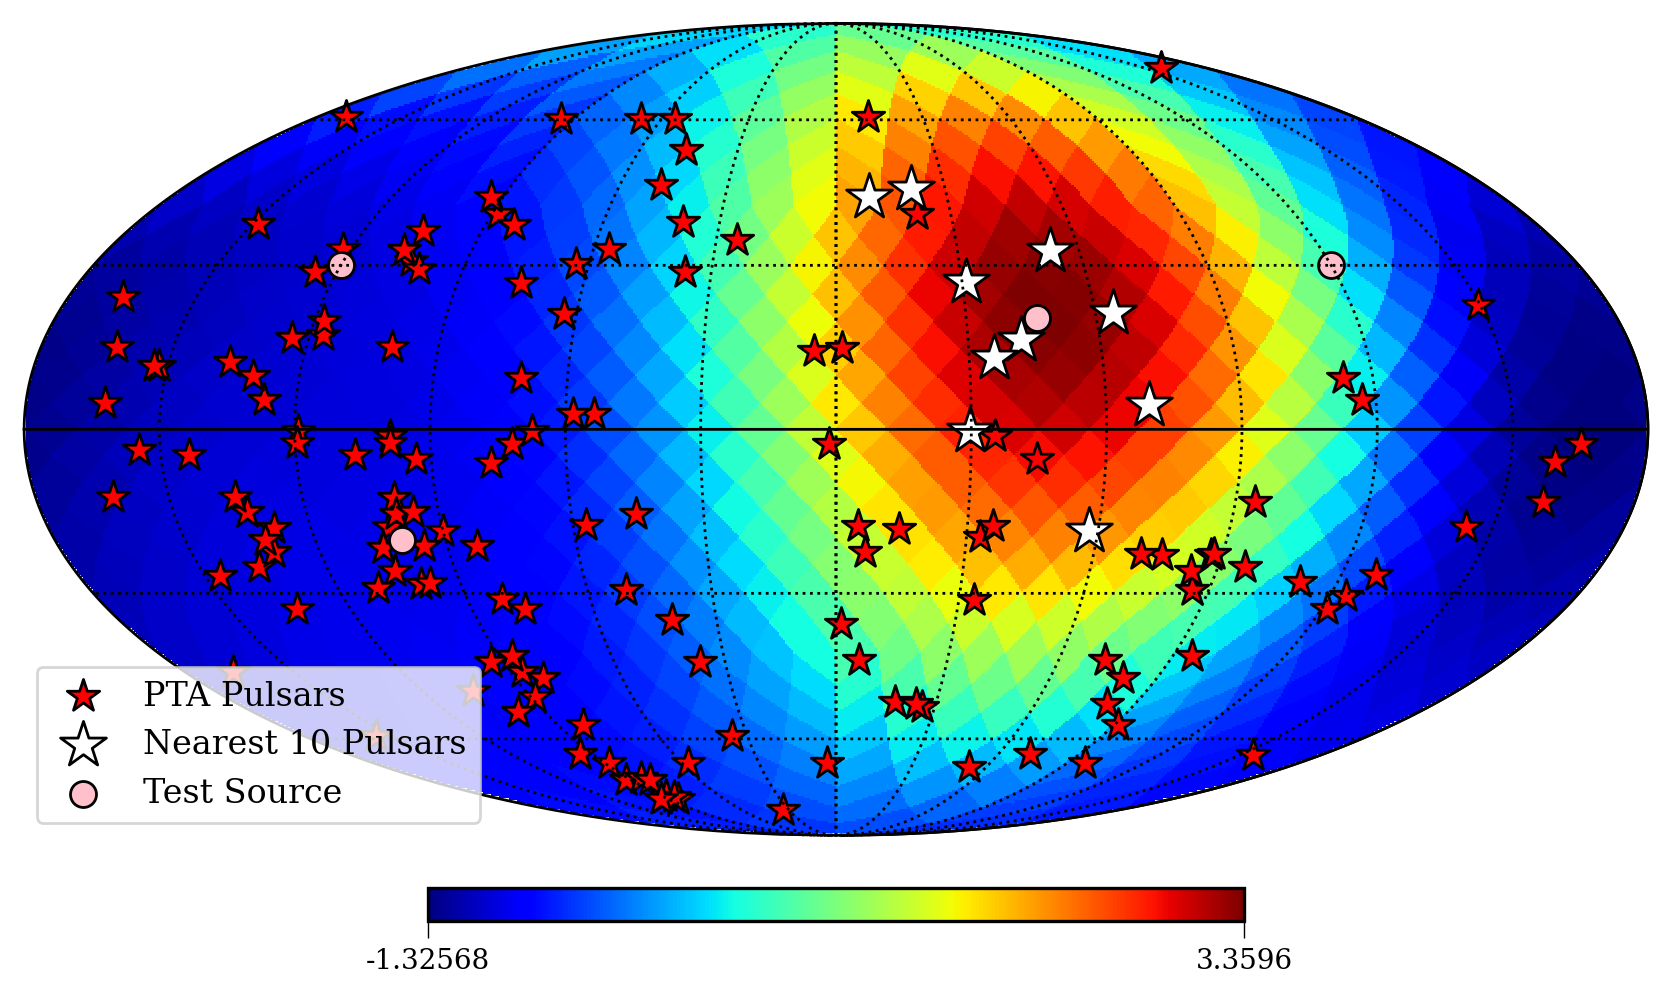

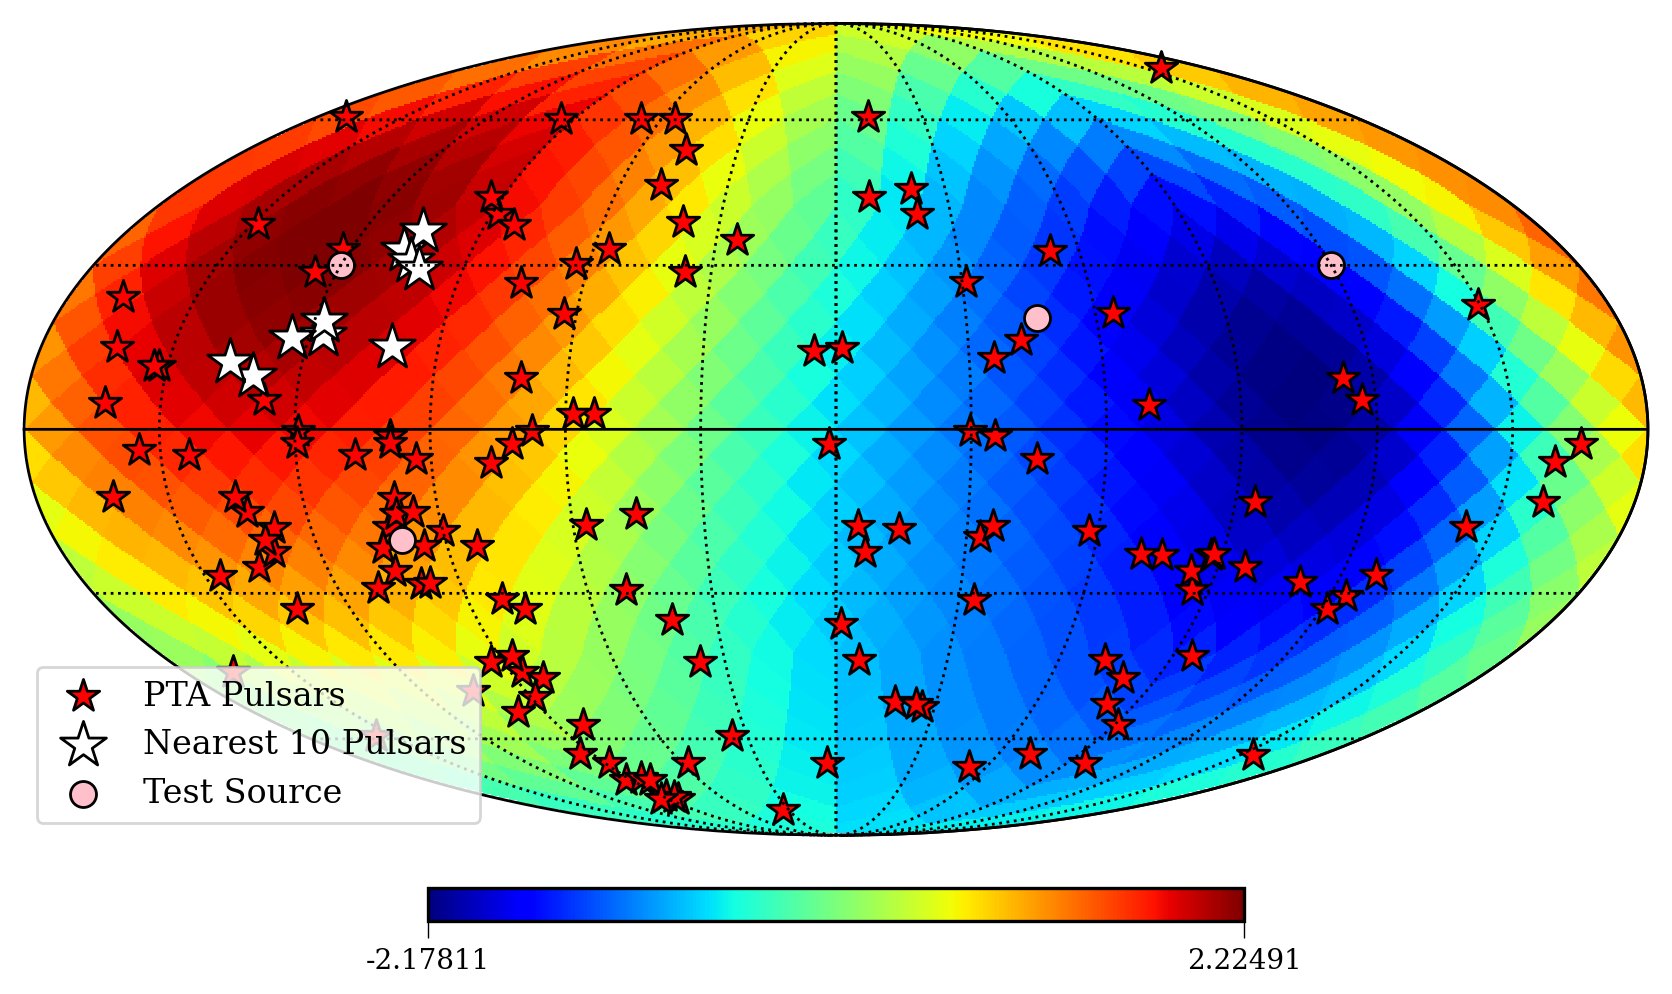

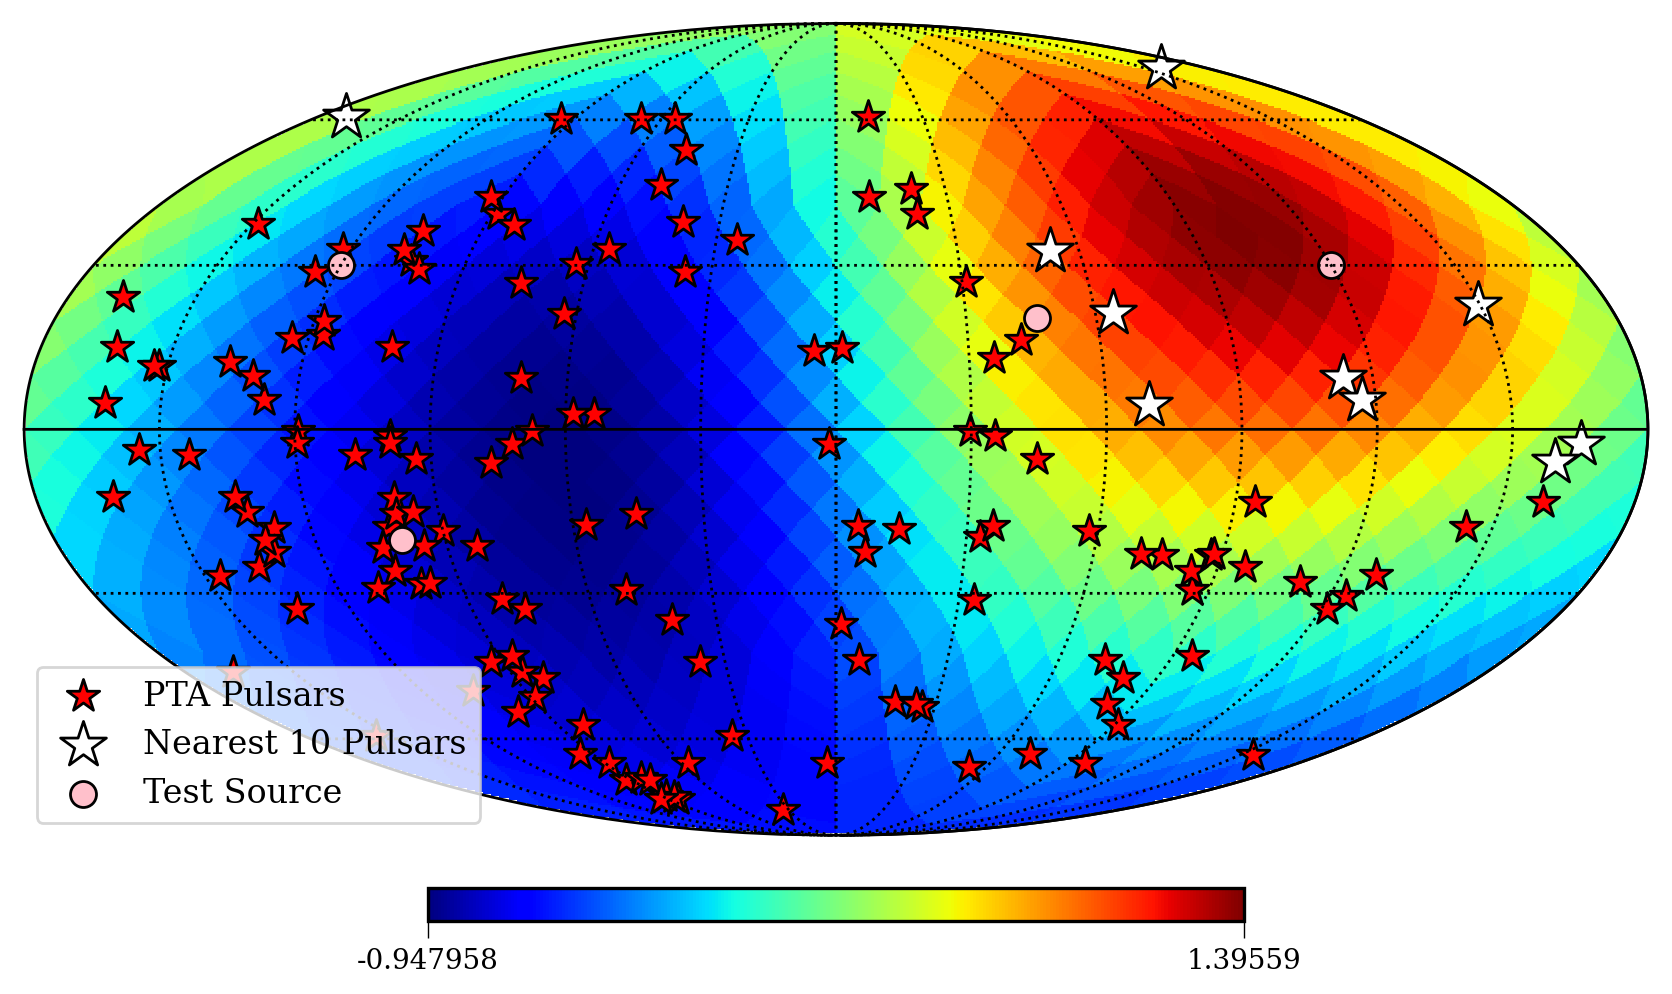

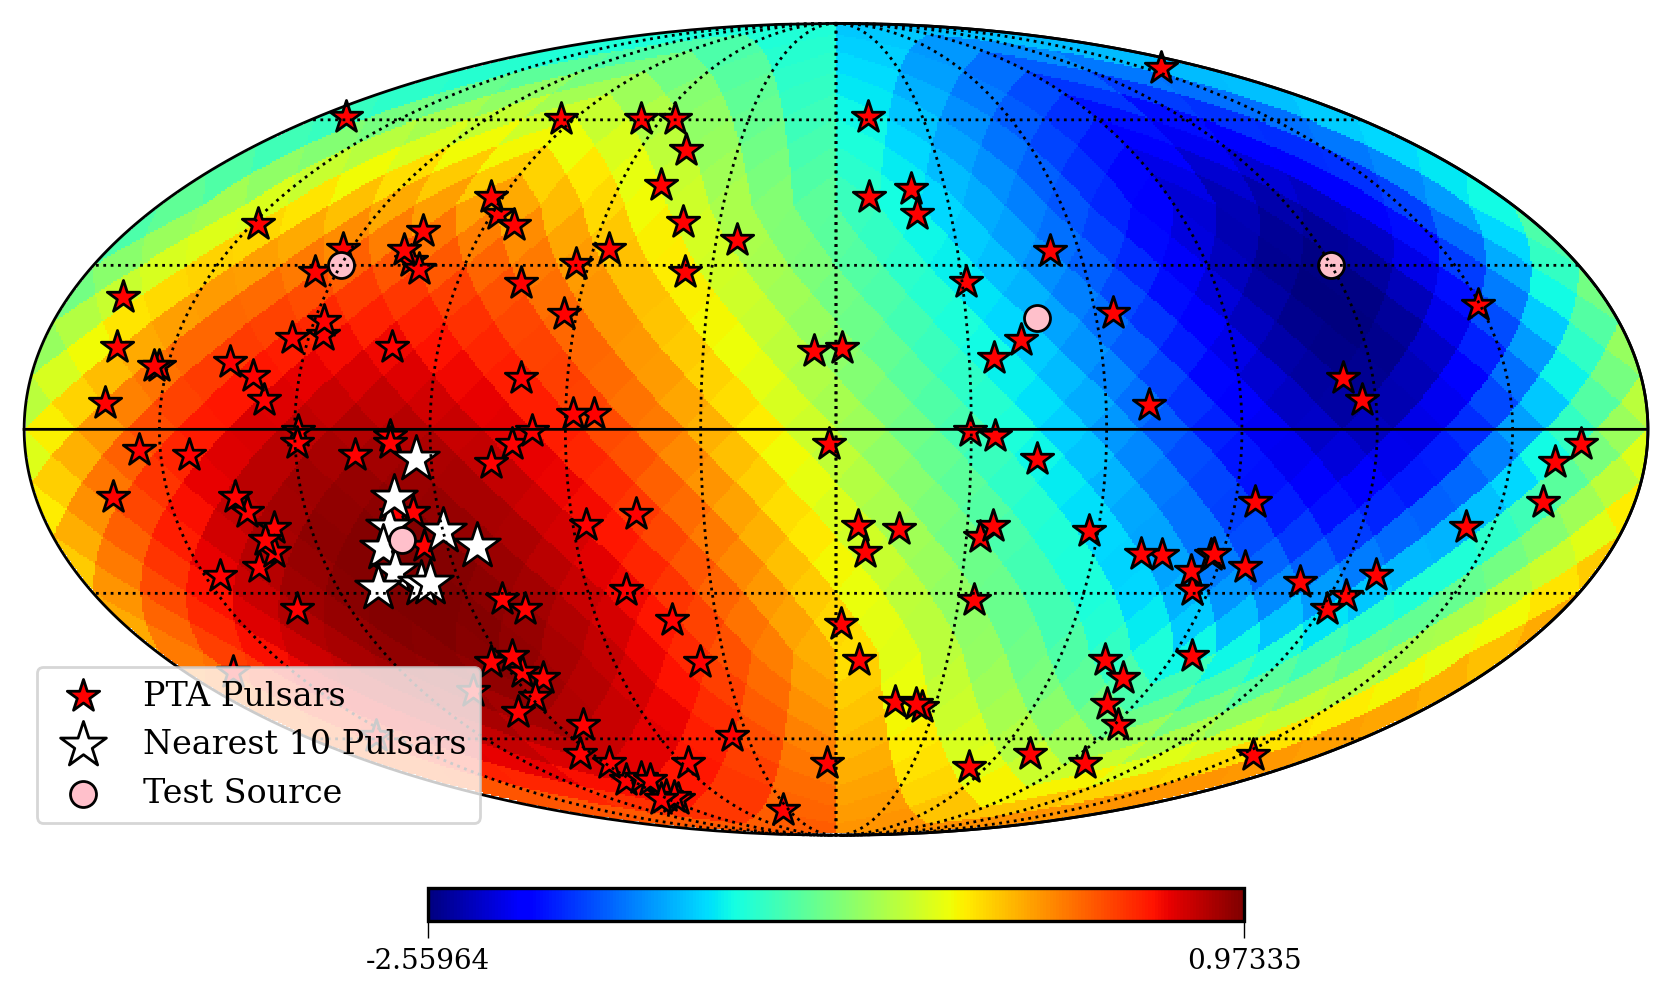

In [75]:
# visualize sources and pulsars
N = 10
src_snr = np.array(SNRs)
for igloo, src_idx in enumerate(range(4)):
    hp.mollview(100*(src_snr[N*(igloo+1)][source_freq]-src_snr[0][source_freq])/(src_snr[0][source_freq]), rot = (180,0,0),
                cmap='jet',cbar=True,title='', )#max=100.685, min = 99.9768)
    #cbar.ax.tick_params(labelsize=10)
    fig = plt.gcf()
    ax = plt.gca()
    hp.graticule()
    hp.visufunc.projscatter(theta_gpta,phi_gpta,marker='*',
                            color='red',edgecolors='k',s=150, label="PTA Pulsars")
    # for src_idx in range(len(source_phis)):
    #     if src_idx == 0:
    hp.visufunc.projscatter([theta_gpta_20yrs[i] for i in nearest_idxs[igloo][:N]], 
                                    [phi_gpta_20yrs[i] for i in nearest_idxs[igloo][:N]], marker='*',
                                    color='white',edgecolors='k',s=300, label = f"Nearest {N} Pulsars")
        # else:
        #     hp.visufunc.projscatter([theta_gpta_20yrs[i] for i in nearest_idxs[src_idx][:N]], 
        #                             [phi_gpta_20yrs[i] for i in nearest_idxs[src_idx][:N]], marker='*',
        #                             color='white' ,edgecolors='k',s=300) 
    hp.visufunc.projscatter(source_thetas, source_phis, marker='.',
                            color='pink',edgecolors='k',s=350, label = "Test Source")
    plt.legend(loc='lower left', fontsize=12)
    #plt.title('Bottom of the bucket SNR@30yrs to Sources 5-8')
    plt.savefig(f'{fig_dir}/psrs_test_srcs_sensitivity.png', dpi=600, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()

In [ ]:
import plot

In [ ]:
source_thetas[0]

<Figure size 875x450 with 0 Axes>

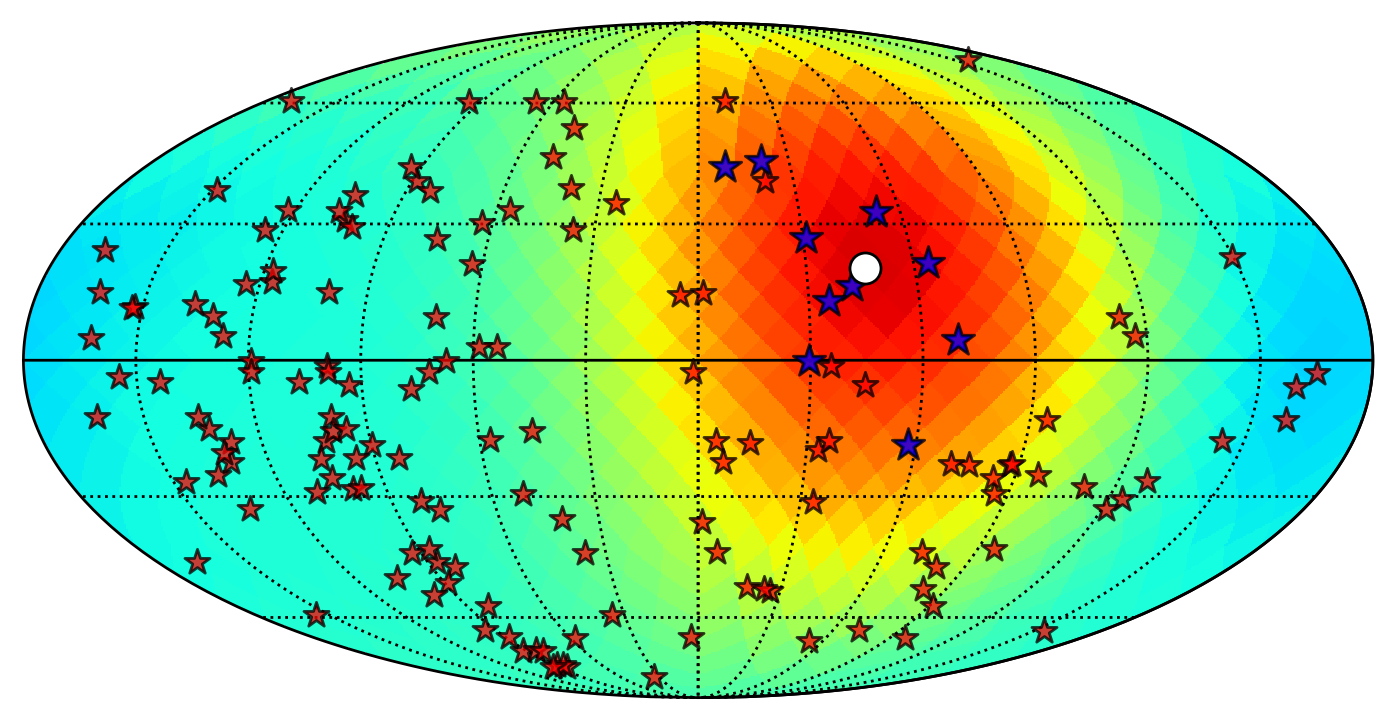

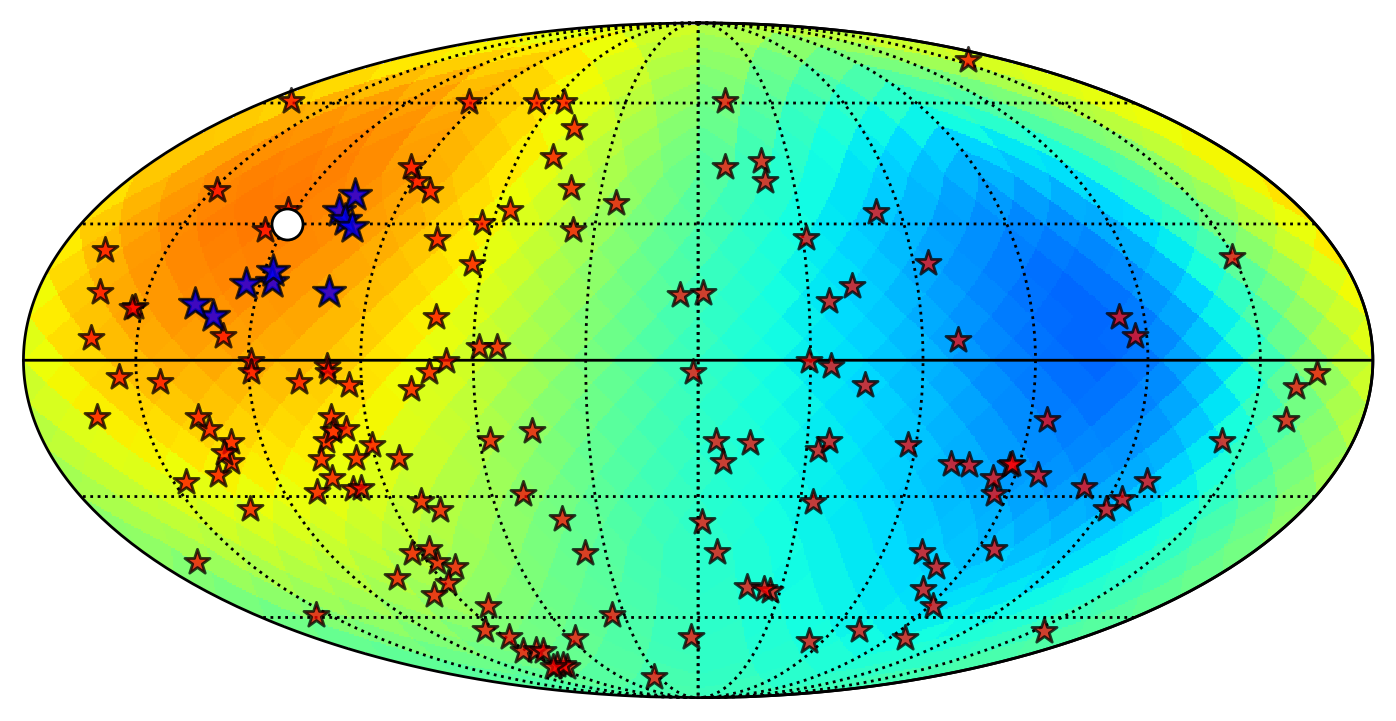

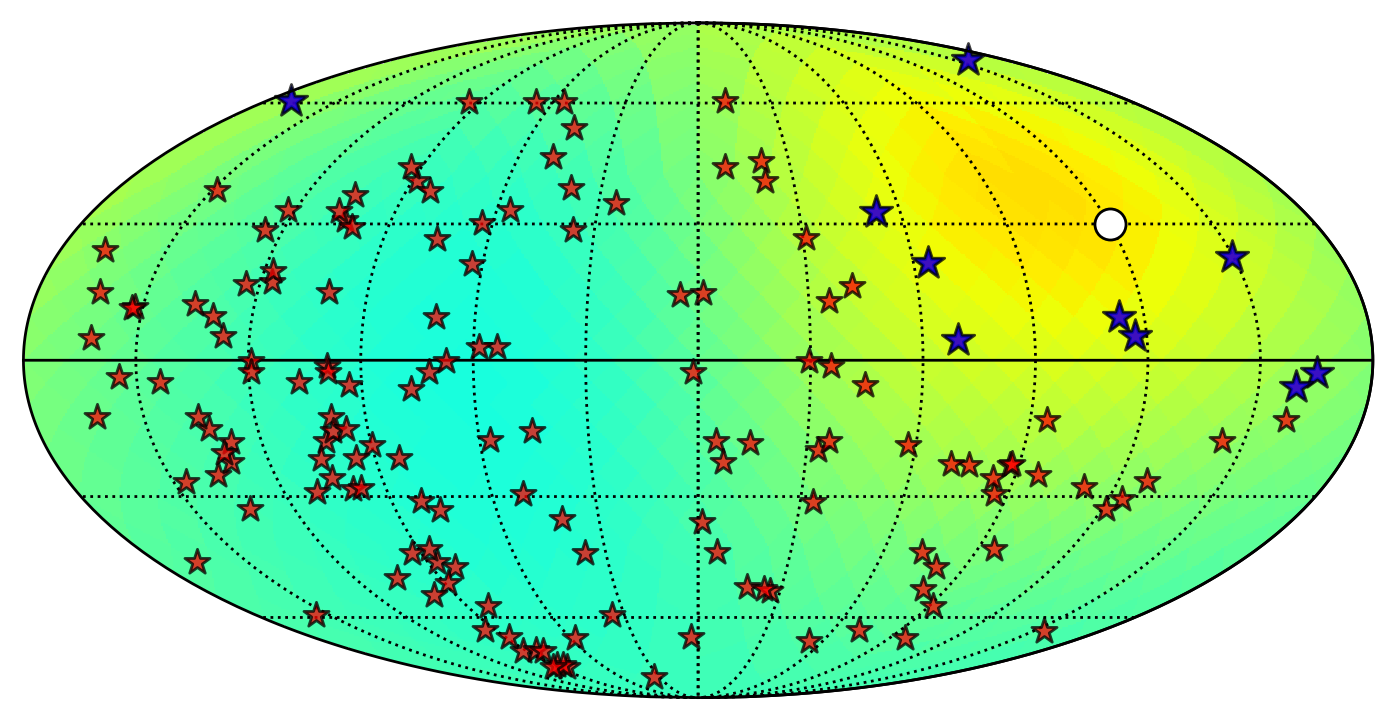

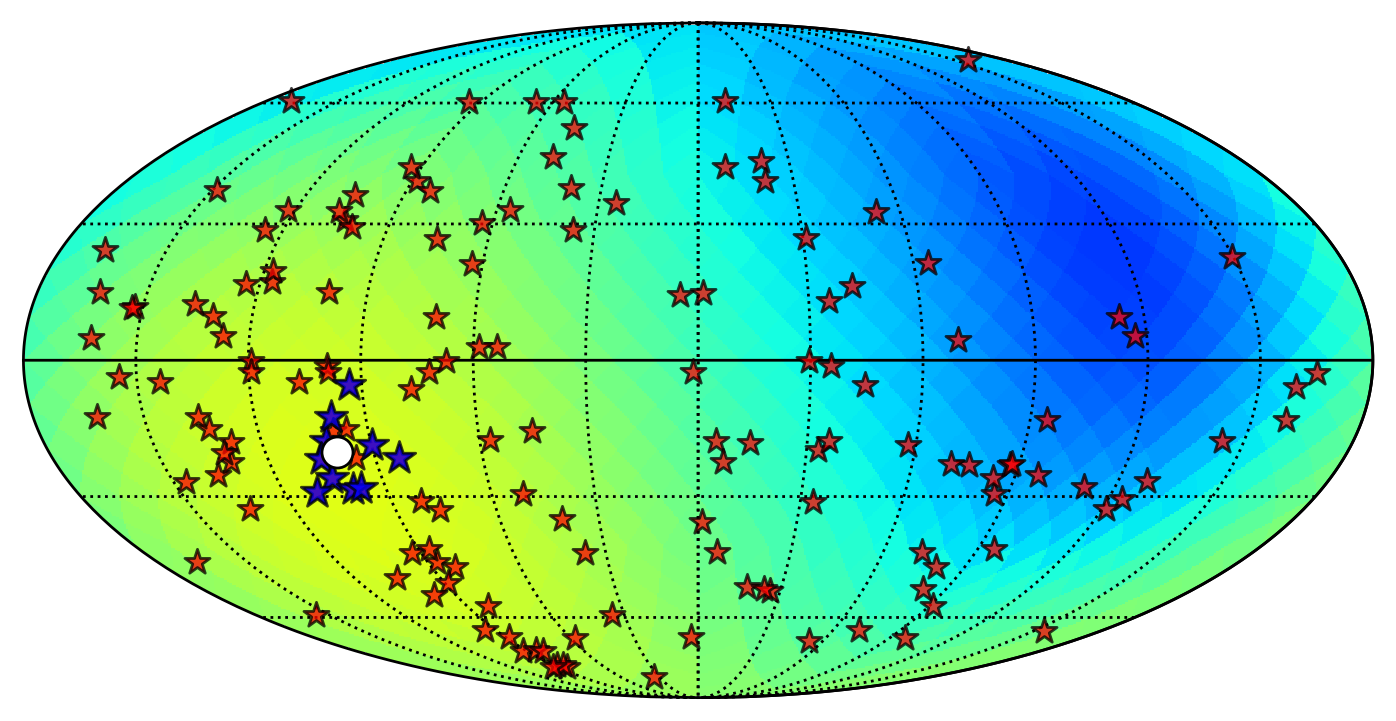

In [76]:
#try to put on one plot
# visualize sources and pulsars
N = 10
src_snr = np.array(SNRs)
fig = plt.figure(figsize=[8.75,4.5],)# layout='constrained')
# fig.set_tight_layout(True)
# spec = mpl.gridspec.GridSpec(ncols=2, nrows=2, height_ratios=[1,1,], width_ratios=[1,1,])
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=2, nrows=2, figsize=[12,8], )#gridspec_kw={'height_ratios': [1, 1]},)
# ax1 = plt.subplot(spec[0,0], projection='mollweide')
# ax2 = plt.subplot(spec[0,1], projection='mollweide')
# ax3 = plt.subplot(spec[1,0], projection='mollweide')
# ax4 = plt.subplot(spec[1,1], projection='mollweide')
#plt.tight_layout()
# axesss = [ax1, ax2, ax3, ax4]
for igloo, src_idx in enumerate(range(4)):
    fig = plt.figure(figsize=[8.75,4.5],)# layout='constrained')
    #plt.tight_layout()
    #plt.sca(axesss[igloo])
    #plt.tight_layout()
    hp.mollview(100*(src_snr[N*(igloo+1)][source_freq]-src_snr[0][source_freq])/(src_snr[0][source_freq]), rot = (180,0,0),
                cmap='jet',cbar=False,title='', hold=True, max=4, min = -4, #cbarticks=[-4,-2,0,2,4]
                )
    plt.gca()
    hp.graticule(zorder=0)
    #cbar.ax.tick_params(labelsize=10)
    #fig = plt.gcf()
    #plt.sca(axesss[igloo])
    hp.visufunc.projscatter(theta_gpta,phi_gpta,marker='*',
                            color='red',edgecolors='k',s=90, label="PTA Pulsars", alpha=0.75#hold=True
                            )
    # for src_idx in range(len(source_phis)):
    hp.visufunc.projscatter([theta_gpta_20yrs[i] for i in nearest_idxs[igloo][:N]], 
                                    [phi_gpta_20yrs[i] for i in nearest_idxs[igloo][:N]], marker='*',
                                    color='blue',edgecolors='k',s=150, label = f"Nearest {N} Pulsars", alpha=0.75 #hold=True
                                    )
        # else:
        #     hp.visufunc.projscatter([theta_gpta_20yrs[i] for i in nearest_idxs[src_idx][:N]], 
        #                             [phi_gpta_20yrs[i] for i in nearest_idxs[src_idx][:N]], marker='*',
        #                             color='white' ,edgecolors='k',s=300) 
    hp.visufunc.projscatter(source_thetas[igloo], source_phis[igloo], marker='.',
                            color='white',edgecolors='k',s=500, label = "Test Source", #hold=True
                            )
# I DONT THINK THIS LINE IS ACTUALLY DOING ANYTHING
#plt.subplots_adjust(wspace=0.001, hspace=0.001,)#left=0, right=0, top=0, bottom=0)
#plt.tight_layout()
#fig = plt.figure(figsize=[10,5], layout='constrained')
# fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0,
#                              wspace=0)
    # cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])  # Adjust the values as needed
    # # norm
    # # cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal', ticks=[-5, 5, 10])
    # cbar_ax.set_xlim(0, 10)
    # cbar_ax.set_yticks([])
    #plt.tight_layout()
    plt.savefig(f'{fig_dir}/skymap_4panel_{igloo}.pdf', dpi=600, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()

In [201]:
freqs[source_freq]

8.002807886528327e-09

/tmp/ipykernel_60393/3631324659.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cmap = plt.cm.get_cmap("jet")
/tmp/ipykernel_60393/3631324659.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


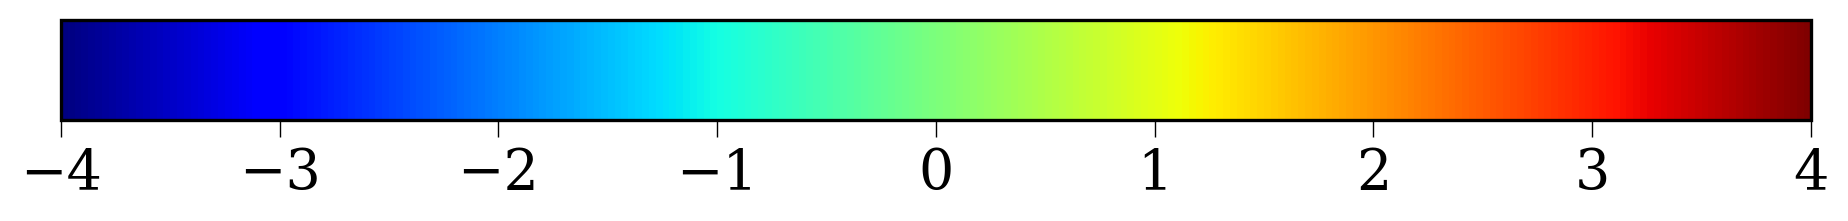

In [181]:
fig = plt.figure(figsize=[8.75,.5],)
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
cbar_ax = fig.add_axes([1, 1, 1, 1])  # Adjust the values as needed
norm = mpl.colors.Normalize(vmin=-4, vmax=4)
cmap = cmap = plt.cm.get_cmap("jet")
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal', ticks=[-5, 5, 10])
cbar_ax.set_xlim(-4, 4)
cbar_ax.set_xticks([-4,-3,-2,-1,0,1,2,3,4],)
cbar_ax.set_yticks([])
plt.tight_layout()
plt.savefig(f'{fig_dir}/skymap_4panel_cbar.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

/tmp/ipykernel_60393/1367386883.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


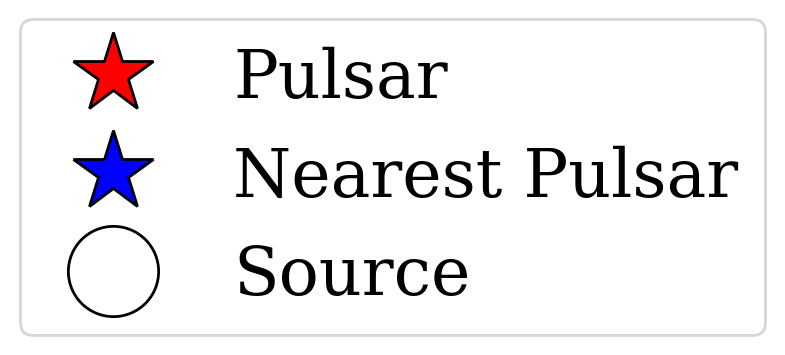

In [198]:
fig = plt.figure(figsize=[0.001,0.001],)
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.xticks([])
plt.yticks([])
legs = [mpl.lines.Line2D([0], [0], color='red', markeredgecolor='k', linestyle='', marker='*', markersize=30, label = 'Pulsar'),
        mpl.lines.Line2D([0], [0], color='blue', markeredgecolor='k', linestyle='', marker='*', markersize=30, label = 'Nearest Pulsar'),
        mpl.lines.Line2D([0], [0], color='White', markeredgecolor='k', linestyle='', marker='.', markersize=65, label = 'Source'),
        ]
plt.legend(handles=legs, loc = (0.3,0.3),fontsize=24)
plt.tight_layout()
plt.savefig(f'{fig_dir}/skymap_4panel_leg.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

#### SO here we see that in an IPTA like set up, swapping for high cadence campaigns nearby the source will not have an impact. 